In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim
import glob2
from itertools import chain
import os
import numpy as np
import itertools
import cPickle as pickle
from  scipy.stats import rankdata
import copy
from openpyxl import Workbook
from openpyxl.compat import range
from openpyxl.utils import get_column_letter
from openpyxl import load_workbook
import pandas as pd
from scipy.stats import hmean
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


2018-03-19 01:03:53,660 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
# ignores everything except english alphabet and  
def only_alphabet(text):
    return ''.join(i for i in text if (ord(i)<123 and ord(i)>96) or (ord(i)<91 and ord(i)>64) or ord(i)==32) 

In [4]:
full_filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        full_filenames.append(filename)
            
filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        filenames.append(os.path.basename(filename))

en_stop = set(get_stop_words('en'))
ps = PorterStemmer()

# "yield" for each file return token list  i.e list of lists
def files_to_tokens(glob_filenames):
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        f = open(filename)
        # read the whole file as lowercase string
        string = only_alphabet(f.read()).lower()
        tokens = []
        # tokenize that string
        for word in word_tokenize(string):
            if word not in en_stop:
                tokens.append(ps.stem(word))

        yield tokens
        f.close()


        
# yields token list for files specific to courts; needed for creating dictionaries
class texts:
    def DCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt')
    def NCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt')
    def SCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt')
    def DelhiHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt')
    def JharkhandHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt')
    def JodhpurHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt')
    def KolkataHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt')
    def SupremeCourt(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt')

# yields bow for each file - tuples id,fq ; needed to train models   
class my_corpus:    
    def DCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/*.txt'):
            yield dictionary.doc2bow(text)
    def NCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)            
    def SCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def DelhiHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JharkhandHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JodhpurHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def KolkataHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def SupremeCourt(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt'):
            yield dictionary.doc2bow(text)
    def everything(self):
        return chain(self.DCDRC(), self.NCDRC(), self.SCDRC(), self.DelhiHC(),
                     self.JharkhandHC(), self.JodhpurHC(), self.KolkataHC(), self.SupremeCourt())
        
        

In [5]:
#################################### laod the dictinary
dictionary = corpora.Dictionary.load('stem100_dictionary')

2018-03-19 01:04:10,699 : INFO : loading Dictionary object from stem100_dictionary
2018-03-19 01:04:10,710 : INFO : loaded stem100_dictionary


In [6]:
######################################## load BOW
corpus = corpora.MmCorpus('stem100.mm')

2018-03-19 01:04:10,835 : INFO : loaded corpus index from stem100.mm.index
2018-03-19 01:04:10,836 : INFO : initializing corpus reader from stem100.mm
2018-03-19 01:04:10,836 : INFO : accepted corpus with 351985 documents, 40069 features, 92572684 non-zero entries


In [ ]:
%%time
from gensim.models import ldamulticore
lda_model = ldamulticore.LdaMulticore(corpus, num_topics=100, id2word = dictionary, workers = 7, eval_every = None, minimum_probability =0.0)

In [ ]:
# for each query : for every document get topic distribution

In [ ]:
lda_model.save('lda_stem100.model')

In [7]:
lda_model = gensim.models.LdaModel.load('lda_stem100.model')

2018-03-19 01:04:10,897 : INFO : loading LdaModel object from lda_stem100.model
2018-03-19 01:04:10,898 : INFO : loading expElogbeta from lda_stem100.model.expElogbeta.npy with mmap=None
2018-03-19 01:04:10,952 : INFO : setting ignored attribute id2word to None
2018-03-19 01:04:10,953 : INFO : setting ignored attribute state to None
2018-03-19 01:04:10,954 : INFO : setting ignored attribute dispatcher to None
2018-03-19 01:04:10,954 : INFO : loaded lda_stem100.model
2018-03-19 01:04:10,955 : INFO : loading LdaModel object from lda_stem100.model.state
2018-03-19 01:04:11,446 : INFO : loaded lda_stem100.model.state


In [8]:
%%time
theta, _ = lda_model.inference(corpus)

CPU times: user 1h 50min 27s, sys: 3h 8min 30s, total: 4h 58min 57s
Wall time: 43min 9s


In [51]:
%%time
theta /= theta.sum(axis=1)[:, None]

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 111 ms


In [52]:
#Save
with open('theta.pkl', 'wb') as output:
    pickle.dump(theta, output, pickle.HIGHEST_PROTOCOL)

In [53]:
# load 
with open('theta.pkl', 'rb') as ip:
    theta = pickle.load(ip)



In [98]:
%%time
topics_terms = lda_model.state.get_lambda()
topics_terms = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)


CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 25.8 ms


In [102]:
lda_model.show_topics(-1)

[(0,
  u'0.034*"complain" + 0.018*"complaint" + 0.013*"produc" + 0.013*"rs" + 0.012*"op" + 0.011*"insur" + 0.008*"crop" + 0.008*"oppon" + 0.008*"bank" + 0.007*"file"'),
 (1,
  u'0.084*"notif" + 0.072*"govern" + 0.046*"area" + 0.019*"land" + 0.019*"scheme" + 0.015*"panchayat" + 0.015*"declar" + 0.014*"notifi" + 0.009*"crop" + 0.009*"central"'),
 (2,
  u'0.063*"dh" + 0.043*"appel" + 0.031*"respond" + 0.018*"dk" + 0.018*"gs" + 0.018*"dbcivil" + 0.017*"eap" + 0.016*"ifjoknh" + 0.015*"ifjokn" + 0.014*"ij"'),
 (3,
  u'0.022*"op" + 0.020*"complain" + 0.020*"orssbcwp" + 0.016*"orssbcivil" + 0.015*"sbcwp" + 0.011*"crop" + 0.010*"complaint" + 0.009*"insur" + 0.009*"sri" + 0.009*"orssb"'),
 (4,
  u'0.057*"appeal" + 0.030*"appel" + 0.023*"delay" + 0.022*"file" + 0.020*"court" + 0.014*"applic" + 0.013*"judgment" + 0.012*"order" + 0.011*"condon" + 0.011*"limit"'),
 (5,
  u'0.184*"amp" + 0.015*"complain" + 0.013*"parti" + 0.010*"polici" + 0.010*"opposit" + 0.007*"said" + 0.006*"rs" + 0.006*"also" + 0

In [101]:
lda_model.get_term_topics('water')

[(0, 0.00069216547869140998),
 (1, 0.00027016586276777091),
 (2, 4.0600979217536108e-05),
 (3, 0.00069650467406442019),
 (4, 8.2777035359895252e-05),
 (5, 0.00025831300484823941),
 (6, 2.3996768823134912e-05),
 (7, 0.021259661076609992),
 (8, 0.00086489127456053903),
 (9, 9.0274574929714944e-05),
 (10, 0.00010687264832424646),
 (11, 0.00064848219532373616),
 (12, 1.9220057549730635e-05),
 (13, 0.00033341007153877303),
 (14, 0.00055999681020004485),
 (15, 0.002506859693572209),
 (16, 0.00032852403373556167),
 (17, 0.00064557025866001717),
 (18, 6.2953801852063716e-05),
 (19, 6.6779893029569109e-05),
 (20, 0.00050824815495592135),
 (21, 0.00038821221753946726),
 (22, 3.9617845172352863e-05),
 (23, 0.00079451629476485108),
 (24, 0.0006394284175378881),
 (25, 0.00092816165186045412),
 (26, 0.0024243430823489213),
 (27, 0.00031072716028972383),
 (28, 0.00038774618876272692),
 (29, 0.00014732814773317859),
 (30, 0.00072413428015564714),
 (31, 0.00068820736892786496),
 (32, 0.0003771986973073

In [12]:
# get the query truth in dictionary
query_truth = {}
for i in range(1,11):
    query_truth[str(i)]=[]
    
    
f = open('LegalAdhocTask/Consumer.qrels')
lines = [line.rstrip('\n').split("\t") for line in f]
for line in lines:
    del line[1]
    query_truth[line[0]].append(line[1:])


In [15]:
query_truth['1']


[['ConsumerCourt_DCDRC_100385', '1'],
 ['ConsumerCourt_DCDRC_106530', '0'],
 ['ConsumerCourt_DCDRC_107608', '1'],
 ['ConsumerCourt_DCDRC_114291', '1'],
 ['ConsumerCourt_DCDRC_114382', '1'],
 ['ConsumerCourt_DCDRC_118185', '1'],
 ['ConsumerCourt_DCDRC_130318', '0'],
 ['ConsumerCourt_DCDRC_130570', '1'],
 ['ConsumerCourt_DCDRC_131146', '1'],
 ['ConsumerCourt_DCDRC_131717', '1'],
 ['ConsumerCourt_DCDRC_131741', '1'],
 ['ConsumerCourt_DCDRC_131818', '1'],
 ['ConsumerCourt_DCDRC_131950', '0'],
 ['ConsumerCourt_DCDRC_131972', '0'],
 ['ConsumerCourt_DCDRC_132932', '0'],
 ['ConsumerCourt_DCDRC_133592', '1'],
 ['ConsumerCourt_DCDRC_134386', '0'],
 ['ConsumerCourt_DCDRC_135474', '1'],
 ['ConsumerCourt_DCDRC_139024', '0'],
 ['ConsumerCourt_DCDRC_139205', '0'],
 ['ConsumerCourt_DCDRC_140039', '1'],
 ['ConsumerCourt_DCDRC_145708', '0'],
 ['ConsumerCourt_DCDRC_187214', '1'],
 ['ConsumerCourt_DCDRC_207784', '1'],
 ['ConsumerCourt_DCDRC_217344', '1'],
 ['ConsumerCourt_DCDRC_217471', '1'],
 ['ConsumerC

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.matutils as gm

In [85]:
def sim_matrix(query, sim_fn):
    docs = query_truth[str(query)]
    docs.sort(key = lambda x : -int(x[1]))
    n = 0
    for i in docs:
        n = n + int(i[1])
    s  = len(docs)
    m = np.zeros((s,s))
    for i in xrange(s):
        for j in xrange(i + 1, s):
            v1 = theta[filenames.index(docs[i][0] + '.txt')]
            v2 = theta[filenames.index(docs[j][0] + '.txt')]
            if sim_fn == gm.cossim:
                v1 = gm.dense2vec(v1)
                v2 = gm.dense2vec(v2)
            m[i, j] = (1 - sim_fn(v1, v2))
    #print m
    print 'Query', query
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10) 
    ax.matshow(m, cmap=plt.cm.Blues)
    ax.hlines(n -0.5, n -0.5, s - 0.5, lw=2, color='r')
    ax.vlines(n -0.5, -0.5, n - 0.5, lw=2, color='r')
    plt.show()


Query 1


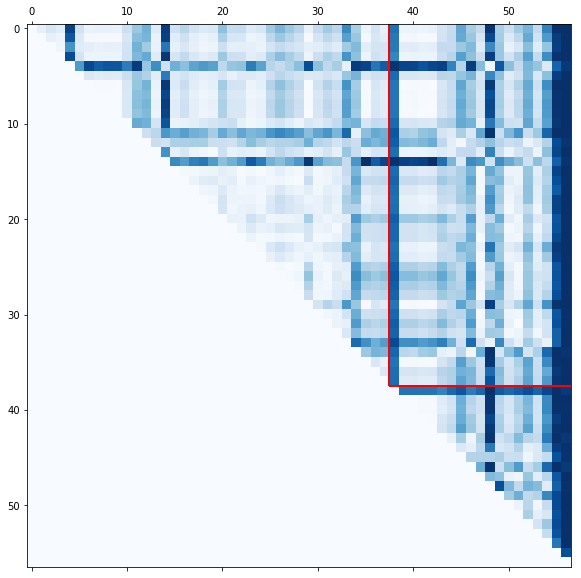

Query 2


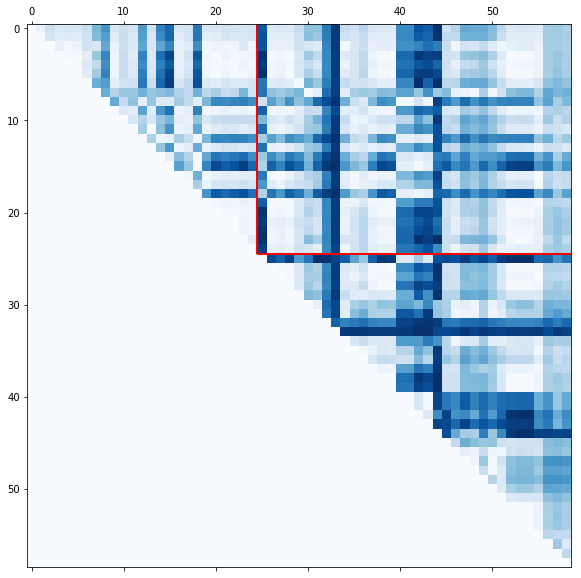

Query 3


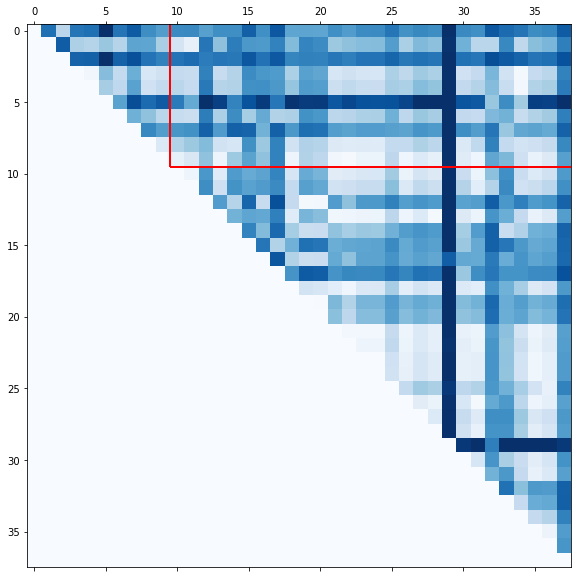

Query 4


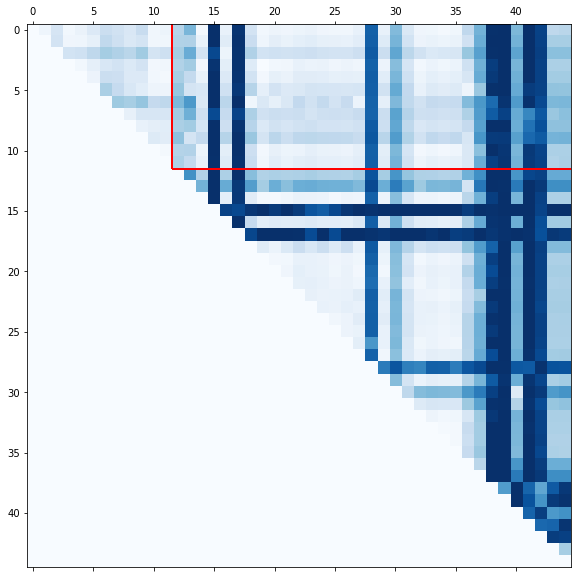

Query 5


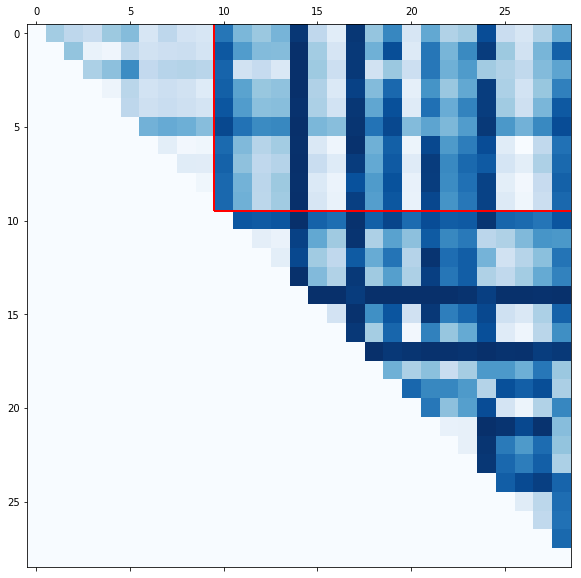

Query 6


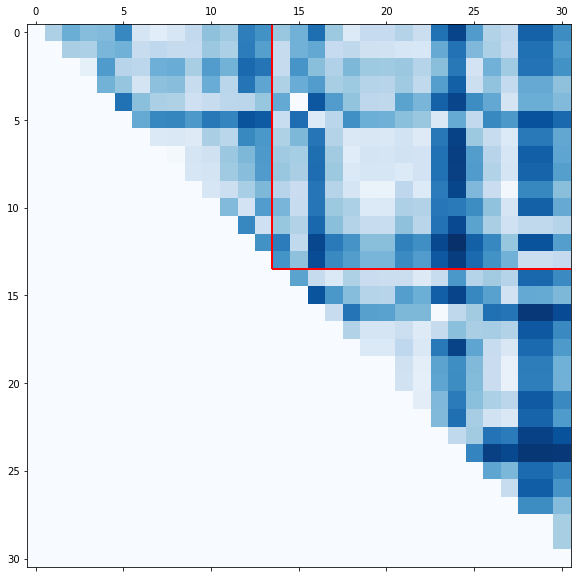

Query 7


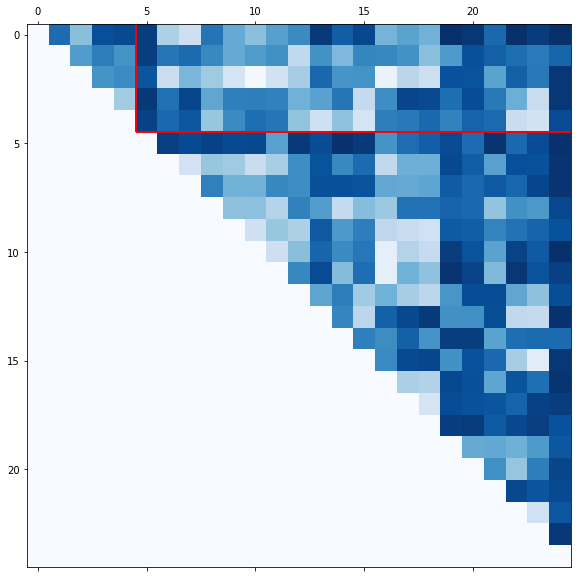

Query 8


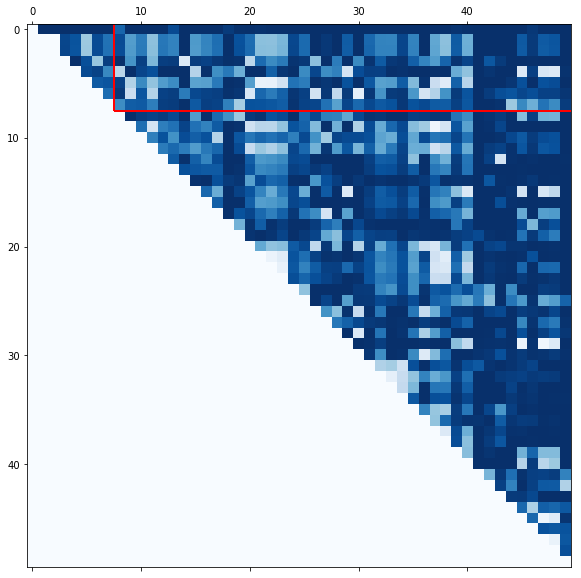

Query 9


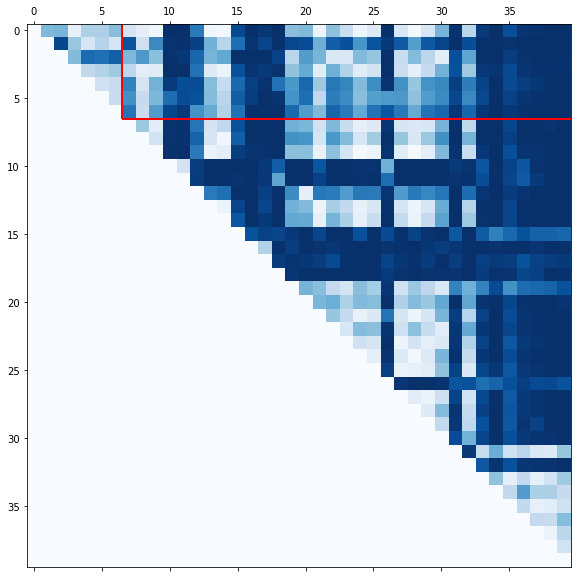

Query 10


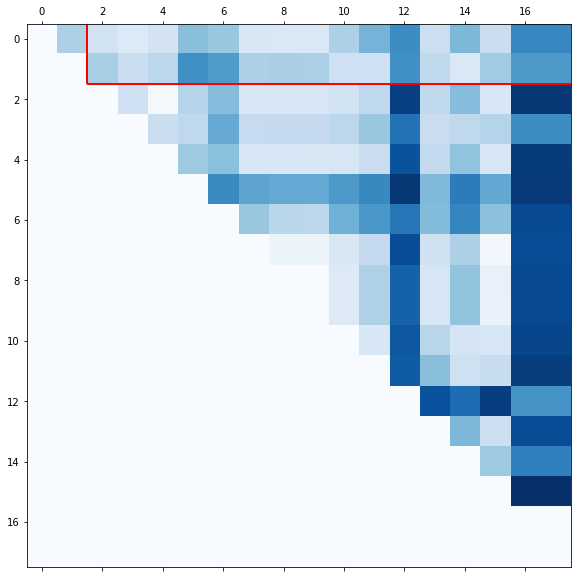

CPU times: user 34.1 s, sys: 2.29 s, total: 36.4 s
Wall time: 33.2 s


In [93]:
%%time
for query in xrange(1, 11):
    sim_matrix(query, gm.cossim)

Query 1


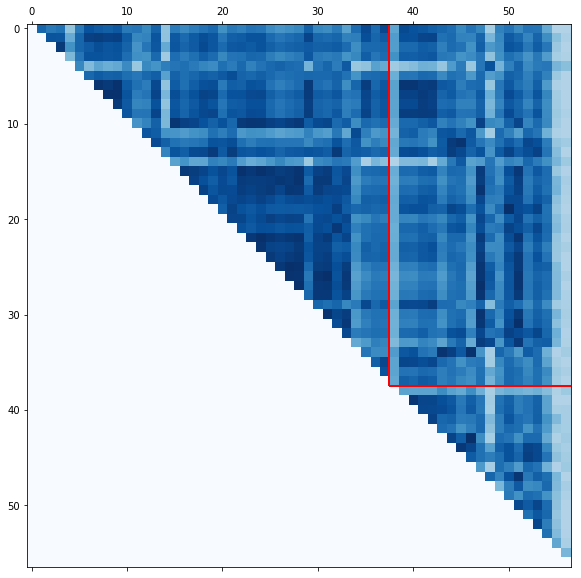

Query 2


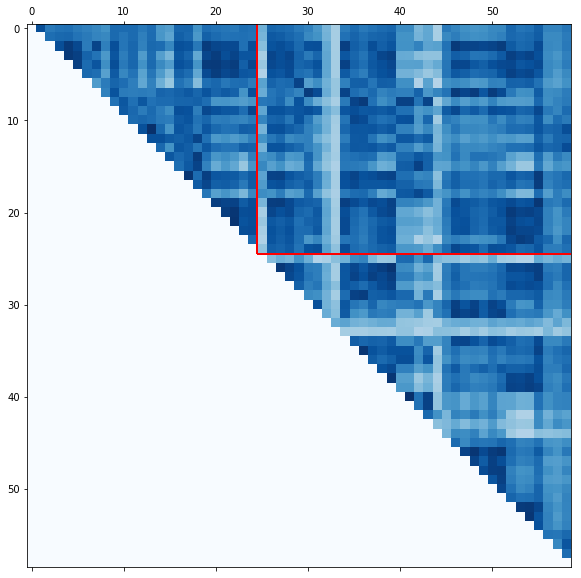

Query 3


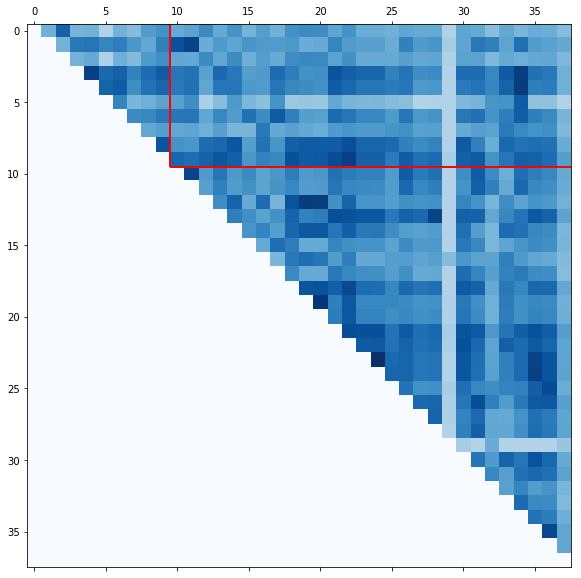

Query 4


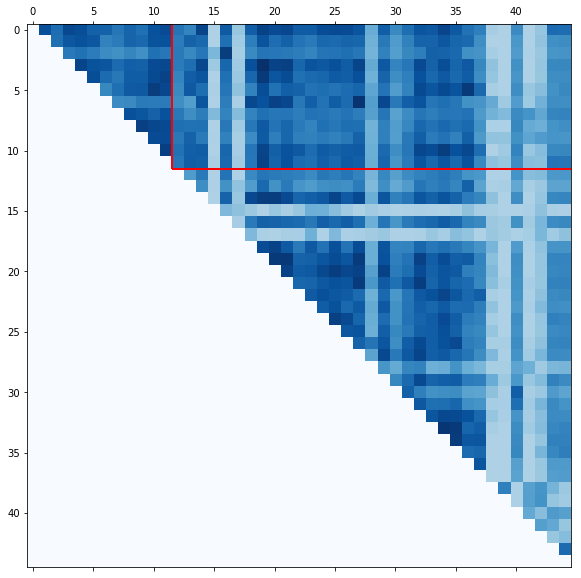

Query 5


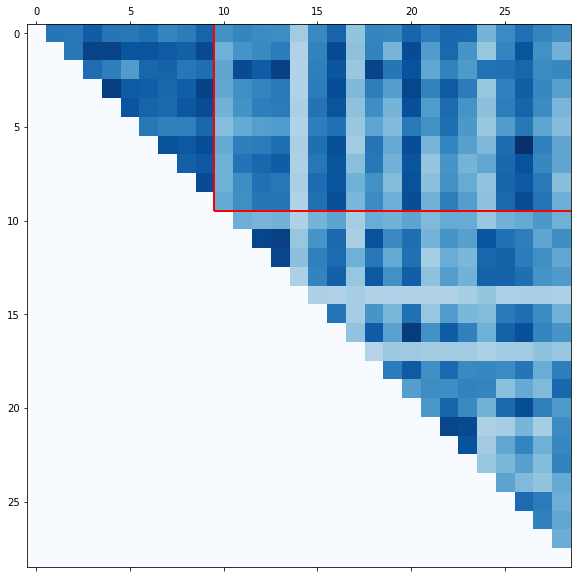

Query 6


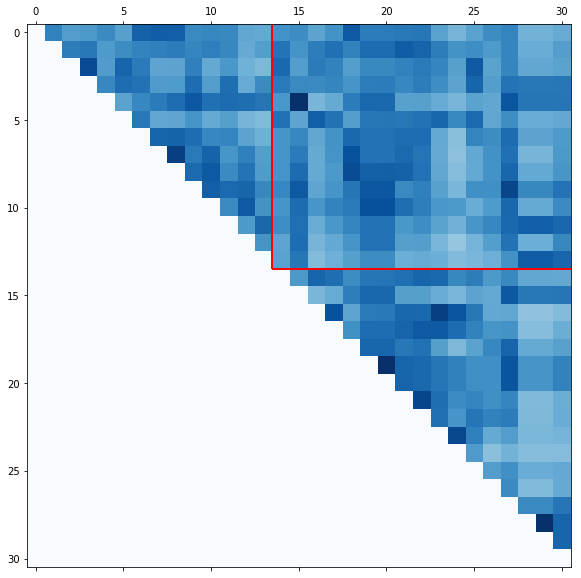

Query 7


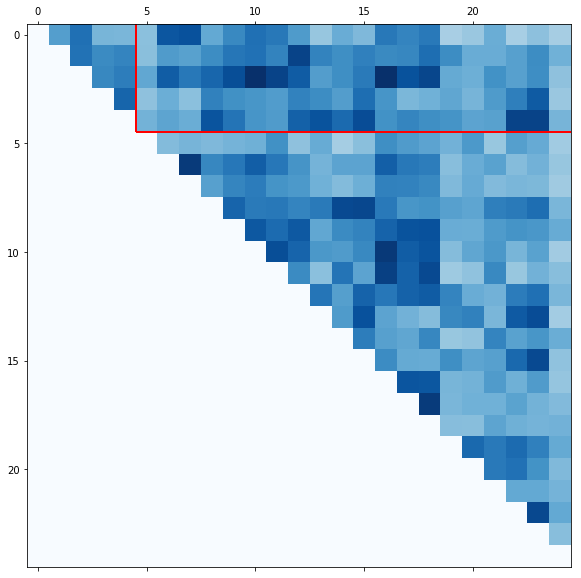

Query 8


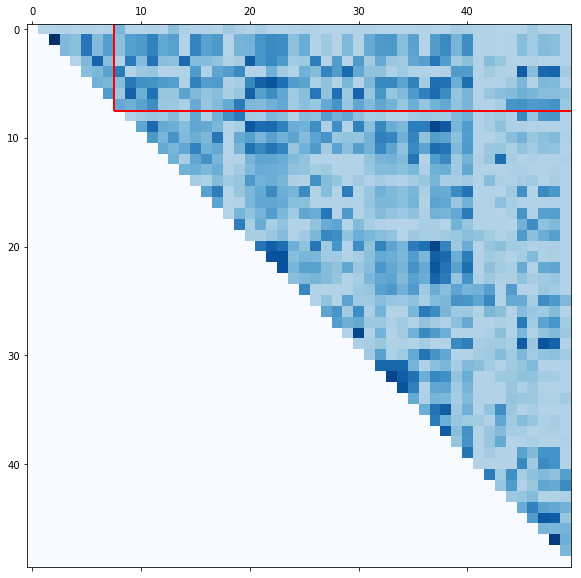

Query 9


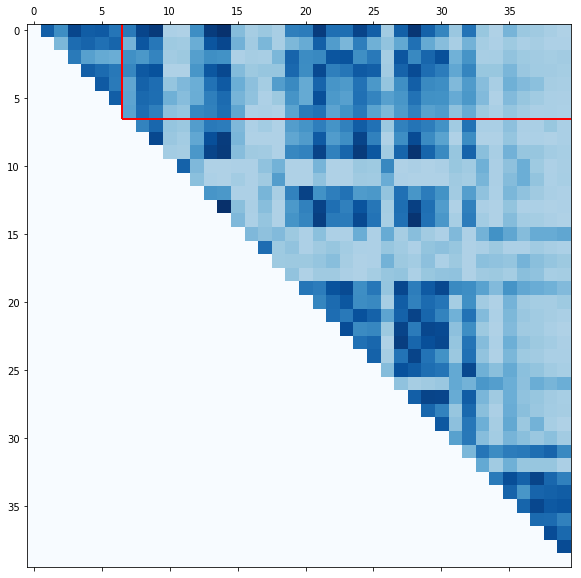

Query 10


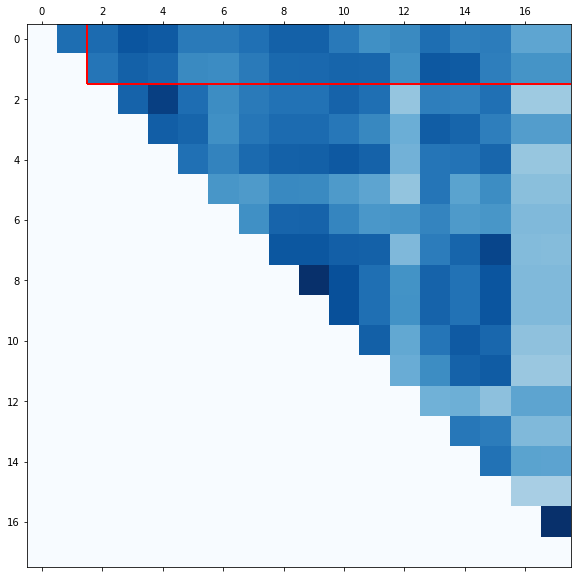

CPU times: user 34.3 s, sys: 2.67 s, total: 36.9 s
Wall time: 33.6 s


In [89]:
%%time
for query in xrange(1, 11):
    sim_matrix(query, gm.jensen_shannon)

Query 1


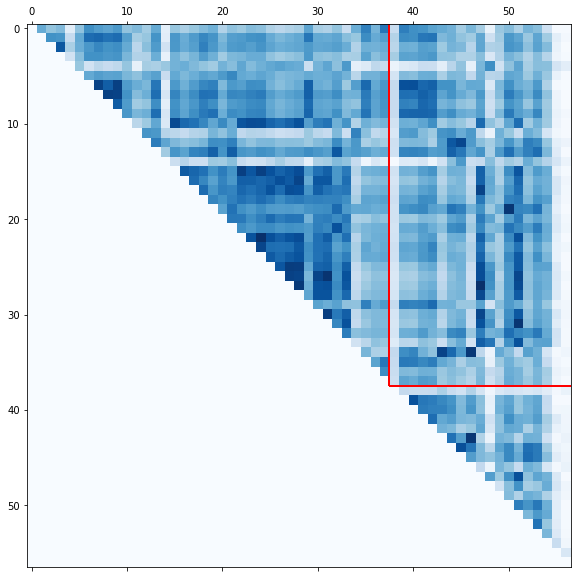

Query 2


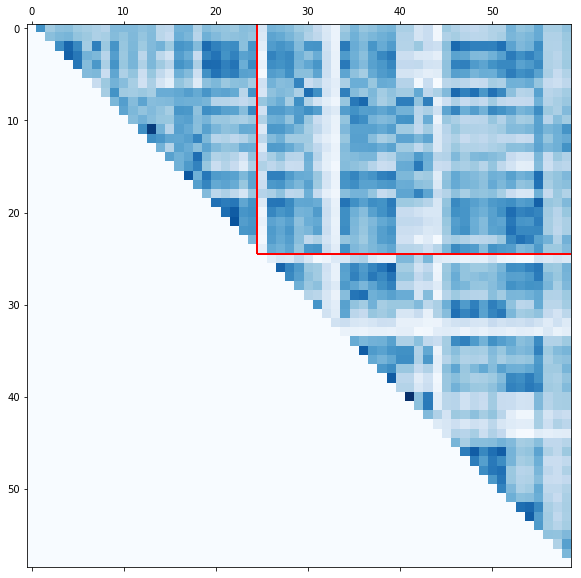

Query 3


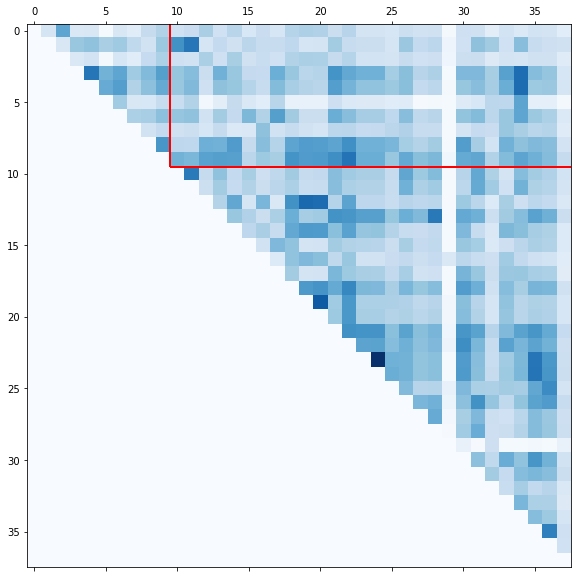

Query 4


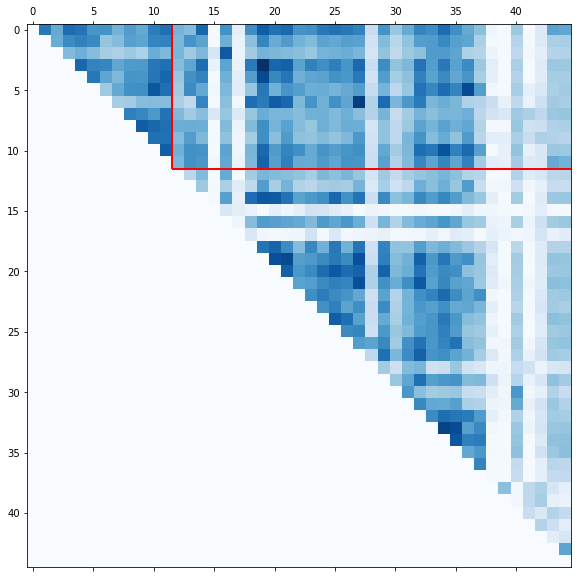

Query 5


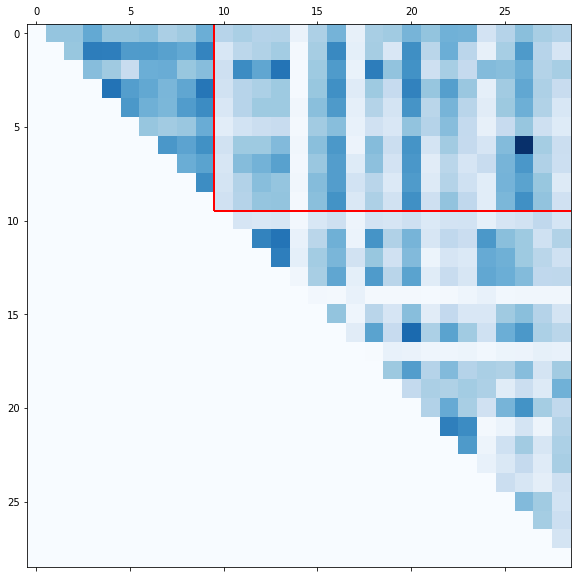

Query 6


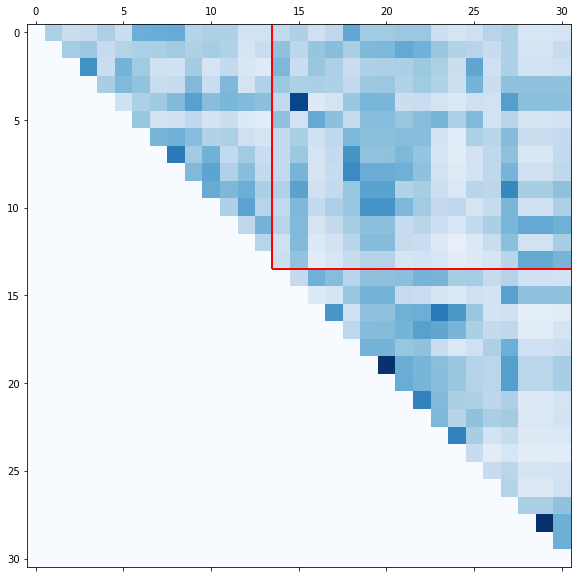

Query 7


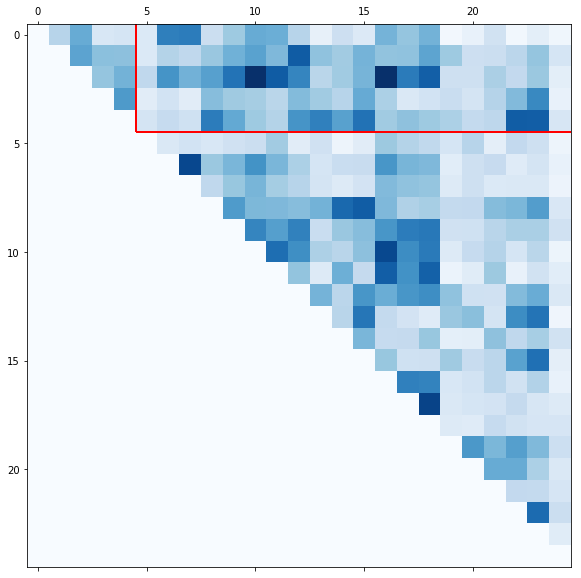

Query 8


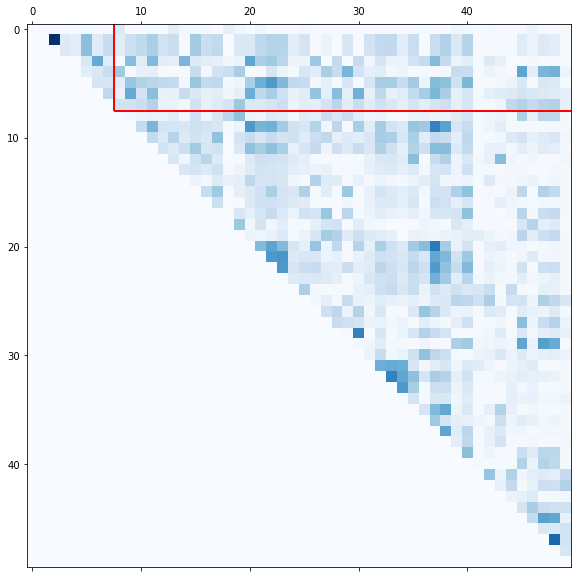

Query 9


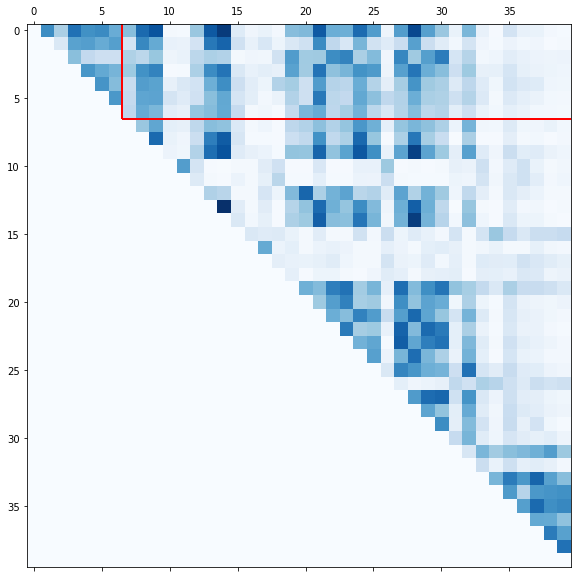

Query 10


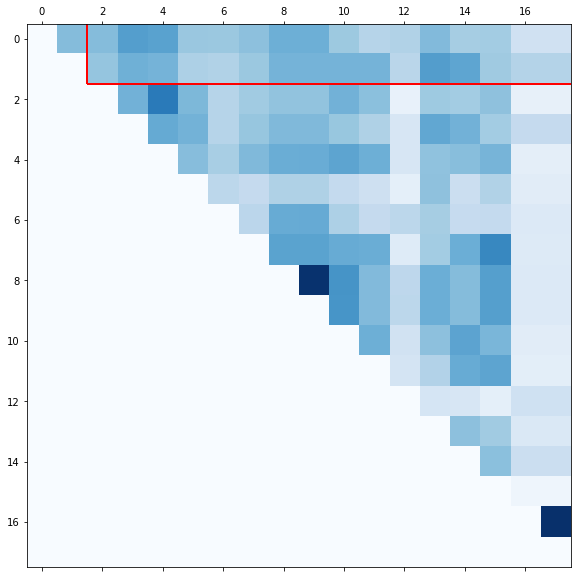

CPU times: user 33.6 s, sys: 2.46 s, total: 36.1 s
Wall time: 32.9 s


In [77]:
%%time
for query in xrange(1, 11):
    sim_matrix(query, gm.hellinger)

In [ ]:

import math
from six import iteritems
from six.moves import xrange



class Lda(object):

    def __init__(self, corpus):
        self.corpus_size = dictionary.num_docs
        s = 0
        for i in corpus:
            for x in i:
                s = s + x[1]
        s = float(s)    
        self.avgdl = s / self.corpus_size
        self.corpus = corpus
        self.df = dictionary.dfs
        self.idf = {}
        self.initialize()

    def initialize(self):
        for word, freq in iteritems(self.df):
            self.idf[word] = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)

    def get_score(self, query, index, average_idf):
        score = 0
        index_doc = dict(self.corpus[index])
        
        for word,freq in query:
            if word not in index_doc:
                continue
            idf = self.idf[word] if self.idf[word] >= 0 else EPSILON * average_idf
            score += freq*((idf * index_doc[word] * (PARAM_K1 + 1)
                      / (index_doc[word] + PARAM_K1 * (1 - PARAM_B + PARAM_B * doc_len[index] / self.avgdl))))
        return score

    def get_scores(self, query, average_idf):
        scores = []
        for index in xrange(self.corpus_size):
            score = self.get_score(query, index, average_idf)
            scores.append(score)
        return scores

